### TRABAJO PRÁCTICO N° 4 MÉTODOS SUPERVISADOS: REGRESIÓN & CLASIFICACIÓN USANDO LA EHP

#### A. Enfoque de validación

###

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class DivisionDatos:
    def __init__(self):
        self.variables_independientes = ['CH04', 'CH06', 'CAT_OCUP', 'PP02H', 'CH08']
        self.datos = None
        
    def cargar_datos(self, archivo="Base_Respondieron.xlsx"):
        self.datos = pd.read_excel(archivo)
        columnas_necesarias = ['ESTADO', 'ANO4'] + self.variables_independientes
        self.datos = self.datos.dropna(subset=columnas_necesarias)
        return self
    
    def preparar_variables(self, df):
        y = (df['ESTADO'] == 'Desocupado').astype(int)
        X = pd.get_dummies(df[self.variables_independientes], drop_first=True)
        X.insert(0, 'intercepto', 1)
        return X, y
    
    def dividir_por_año(self, año):
        df_año = self.datos[self.datos['ANO4'] == año].copy()
        if len(df_año) == 0:
            return None
        
        X, y = self.preparar_variables(df_año)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=444, stratify=y)
        
        return {
            'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'df_año': df_año, 'año': año
        }
    
    def guardar_datasets(self, resultado):
        año = resultado['año']
        
        train_df = resultado['X_train'].copy()
        train_df['y_desocupado'] = resultado['y_train'].values
        test_df = resultado['X_test'].copy()
        test_df['y_desocupado'] = resultado['y_test'].values
        
        train_df.astype(int).to_excel(f'train_data_{año}.xlsx', index=False)
        test_df.astype(int).to_excel(f'test_data_{año}.xlsx', index=False)
        
        df_año = resultado['df_año']
        X_original, y_original = self.preparar_variables(df_año)
        X_train_temp, X_test_temp, _, _ = train_test_split(X_original, y_original, test_size=0.7, random_state=444, stratify=y_original)
        
        df_año.loc[X_train_temp.index].to_excel(f'train_original_{año}.xlsx', index=False)
        df_año.loc[X_test_temp.index].to_excel(f'test_original_{año}.xlsx', index=False)
    
    def procesar_todos_los_años(self):
        for año in sorted(self.datos['ANO4'].unique()):
            resultado = self.dividir_por_año(año)
            if resultado:
                self.guardar_datasets(resultado)

def main():
    DivisionDatos().cargar_datos().procesar_todos_los_años()

if __name__ == "__main__":
    main() 

In [2]:
class AnalisisDiferenciasMedias:
    def __init__(self):
        self.años = [2004, 2024]
        
    def cargar_bases(self, año):
        train_df = pd.read_excel(f'train_data_{año}.xlsx')
        test_df = pd.read_excel(f'test_data_{año}.xlsx')
        return train_df, test_df
    
    def calcular_diferencias_medias(self, train_df, test_df, año):
        variables_x = [col for col in train_df.columns if col != 'y_desocupado']
        
        train_x = train_df[variables_x]
        test_x = test_df[variables_x]
        
        medias_train = train_x.mean()
        medias_test = test_x.mean()
        
        tabla_diferencias = pd.DataFrame({
            'Variable': variables_x,
            'Media_Train': medias_train.values,
            'Media_Test': medias_test.values,
            'Diferencia': (medias_train - medias_test).values,
            'Diferencia_Abs': abs(medias_train - medias_test).values,
            'Año': año
        })
        
        tabla_diferencias = tabla_diferencias.sort_values('Diferencia_Abs', ascending=False)
        return tabla_diferencias
    
    def analizar_todos_los_años(self):
        for año in self.años:
            train_df, test_df = self.cargar_bases(año)
            tabla = self.calcular_diferencias_medias(train_df, test_df, año)
            
            print(f"Año {año}:")
            print(f"  Variables: {len(tabla)}")
            print(f"  Mayor diferencia: {tabla['Diferencia_Abs'].max():.4f}")
            print(f"  Promedio diferencias: {tabla['Diferencia_Abs'].mean():.4f}")
            
            print("  Top 3 mayores diferencias:")
            for i, (_, row) in enumerate(tabla.head(3).iterrows()):
                print(f"    {i+1}. {row['Variable']}: {row['Diferencia']:.4f}")
            print()

analizador = AnalisisDiferenciasMedias()
analizador.analizar_todos_los_años()

Año 2004:
  Variables: 102
  Mayor diferencia: 0.0138
  Promedio diferencias: 0.0019
  Top 3 mayores diferencias:
    1. CH04_Varón: 0.0138
    2. CH08_No paga ni le descuentan: 0.0115
    3. CH08_Obra social (incluye PAMI): -0.0094

Año 2024:
  Variables: 106
  Mayor diferencia: 0.0078
  Promedio diferencias: 0.0018
  Top 3 mayores diferencias:
    1. CH04_Varón: 0.0078
    2. CH08_Obra social (incluye PAMI): 0.0063
    3. CH06_21: -0.0061



#### PARTE B 2 Base de Entrenamiento 2004

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

In [4]:
#Vuelvo a calcular las variables Previamente calculadas del TP3 pero conla base de datos de "TRAININ"
df_trainin = pd.read_excel("train_original_2004.xlsx")

#Variable salario_semanal:
df = pd.read_excel("train_original_2004.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal'] = df['P21'] / 40

#Variable Educ
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ'].describe()

#variable horas trab
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']


#Limpio los Nan y celdas vacías, asumimos que En edades aquellos que todavía no cumple 1 año concreto igualmente lo estan viviendo, apra asi reemplazar los "Menores de 1 año" por 1.

df['horastrab_']= df['horastrab'].fillna(0)
df["CH06_"] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad'] = df["CH06_"].replace('Menos de 1 año', 0)
df["Edad"] = df['edad'].fillna(1)

#vaiable edad2
df["Edad2"] = df["Edad"] **2 

#variable mujer

df["Mujer"] = df["CH04"].map({
    "Mujer": 1,
    "Varón": 2,})
#variable CAT_OCUP DETEERMINA LA RELACIÓN LABORAL (0=NO TIENE O SE ENCUENTRA INACTIVO)
df["Cond_OCU"] = df["CAT_OCUP"].map({
    "Obrero o empleado": 1,
    "Cuenta propia": 2,
    "Patrón": 3
}).fillna(0) 

#VARIABLE CH16 INDICA SI EN DONDE SE ENCEUNTRA SU TRABAJO. (0 si se neiga a responder)

df["UBI_TRA"] = df["CH16"].map({
    "En esta localidad": 1,
    "En otra localidad de esta provincia": 2,
    "En otra provincia (especificar)": 3
}).fillna(0)  

#SALARIO SEMANAL EN EDAD
x= df["Edad"]
y= df['salario_semanal']

x_con = sm.add_constant(x)
model = sm.OLS(y, x_con)
results = model.fit()
print(results.summary())

y_pred = results.predict(x_con)

mse1 = mean_squared_error(y, y_pred)
print("mse1_test:",mse1)

mse2 = np.square(np.subtract(y, y_pred)).mean()
print("mse2_test:",mse2)

#salario semanal en edad y edad2

XEE =df[['Edad', 'Edad2']]
y = df['salario_semanal']

XEE_con = sm.add_constant(XEE)
model_EE = sm.OLS(y, XEE_con)
results_EE = model_EE.fit()
print(results_EE.summary())

YEE_pred = results_EE.predict(XEE_con)
YEE_pred
print("Forma de YEE_pred:", YEE_pred.shape)
print("Dimensiones de YEE:", YEE_pred.ndim)

mse1_EE = mean_squared_error(y, YEE_pred)
print("mse1_test_EE:",mse1_EE)

mse2_EE = np.square(np.subtract(y, YEE_pred)).mean()
print("mse2_test_EE:",mse2_EE)

#SALARIO SEMANAL EN EDAD, EDAD 2 Y EDUCACIÓN
XEEE =df[['Edad', 'Edad2', 'educ']] 
y =df['salario_semanal']

XEEE_con = sm.add_constant(XEEE)
model_EEE = sm.OLS(y, XEEE_con)
results_EEE = model_EEE.fit()
print(results_EEE.summary())

YEEE_pred = results_EEE.predict(XEEE_con)

mse1_EEE = mean_squared_error(y, YEEE_pred)
print("mse1_test_EEE:",mse1_EEE)

mse2_EEE = np.square(np.subtract(y, YEEE_pred)).mean()
print("mse2_test_EEE:",mse2_EEE)

#SALARIO SEMANAL EN EDAD , EDAD2 , EDUC y MUJER
XEEEM =df[['Edad', 'Edad2', 'educ', "Mujer"]] 
y =df['salario_semanal']

XEEEM_con = sm.add_constant(XEEEM)
model_EEEM = sm.OLS(y, XEEEM_con)
results_EEEM = model_EEEM.fit()
print(results_EEEM.summary())

YEEEM_pred = results_EEEM.predict(XEEEM_con)

mse1_EEEM = mean_squared_error(y, YEEEM_pred)
print("mse1_test_EEEM:",mse1_EEEM)

mse2_EEEM = np.square(np.subtract(y, YEEEM_pred)).mean()
print("mse2_test_EEEM:",mse2_EEEM)

#SALARO SEMANAL EN EDAD, EDAD 2, EDUC, MUJER Y UBI_TRA
XEEEMU =df[['Edad', 'Edad2', 'educ', "Mujer","UBI_TRA"]] 
y =df['salario_semanal']

XEEEMU_con = sm.add_constant(XEEEMU)
model_EEEMU = sm.OLS(y, XEEEMU_con)
results_EEEMU = model_EEEMU.fit()
print(results_EEEMU.summary())

YEEEMU_pred = results_EEEMU.predict(XEEEMU_con)

mse1_EEEMU = mean_squared_error(y, YEEEMU_pred)
print("mse1_test_EEEMU:",mse1_EEEMU)

mse2_EEEMU = np.square(np.subtract(y, YEEEMU_pred)).mean()
print("mse2_test_EEEMU:",mse2_EEEMU)

#SALARIO SEMANAL EN EDAD , EDAD2 , EDUC , MUJER y COND_OCUPADOS
XEEEMC =df[['Edad', 'Edad2', 'educ', "Mujer", "Cond_OCU"]] 
y =df['salario_semanal']

XEEEMC_con = sm.add_constant(XEEEMC)
model_EEEMC = sm.OLS(y, XEEEMC_con)
results_EEEMC = model_EEEMC.fit()
print(results_EEEMC.summary())

YEEEMC_pred = results_EEEMC.predict(XEEEMC_con)

mse1_EEEMC = mean_squared_error(y, YEEEMC_pred)
print("mse1_test_EEEMC:",mse1_EEEMC)

mse2_EEEMC = np.square(np.subtract(y, YEEEMC_pred)).mean()
print("mse2_test_EEEMC:",mse2_EEEMC)

                            OLS Regression Results                            
Dep. Variable:        salario_semanal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     25.34
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           5.03e-07
Time:                        22:43:48   Log-Likelihood:                -51240.
No. Observations:                3758   AIC:                         1.025e+05
Df Residuals:                    3756   BIC:                         1.025e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.776e+04   7023.499     11.071      0.0

#### PARTE B, EJERCICIO 3 CON BASE DE TESTEO 2004

In [5]:
#Vuelvo a calcular las variables Previamente calculadas del TP3 pero conla base de datos de "TESTEO"
df_trainin = pd.read_excel("test_original_2004.xlsx")

#Variable salario_semanal:
df = pd.read_excel("test_original_2004.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal_TEST'] = df['P21'] / 40

#Variable Educ
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ_TEST'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ_TEST'].describe()

#variable horas trab
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']


#Limpio los Nan y celdas vacías, asumimos que En edades aquellos que todavía no cumple 1 año concreto igualmente lo estan viviendo, apra asi reemplazar los "Menores de 1 año" por 1.

df['horastrab_']= df['horastrab'].fillna(0)
df["CH06_"] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad'] = df["CH06_"].replace('Menos de 1 año', 0)
df["Edad_TEST"] = df['edad'].fillna(1)

#vaiable edad2
df["Edad2_TEST"] = df["Edad_TEST"] **2 

#variable mujer

df["Mujer_TEST"] = df["CH04"].map({
    "Mujer": 1,
    "Varón": 2,})
#variable CAT_OCUP DETEERMINA LA RELACIÓN LABORAL (0=NO TIENE O SE ENCUENTRA INACTIVO)
df["Cond_OCU_TEST"] = df["CAT_OCUP"].map({
    "Obrero o empleado": 1,
    "Cuenta propia": 2,
    "Patrón": 3
}).fillna(0) 

#VARIABLE CH16 INDICA SI EN DONDE SE ENCEUNTRA SU TRABAJO. (0 si se neiga a responder)

df["UBI_TRA_TEST"] = df["CH16"].map({
    "En esta localidad": 1,
    "En otra localidad de esta provincia": 2,
    "En otra provincia (especificar)": 3
}).fillna(0)  

#Salario Semanal en Edad
x_new=df["Edad_TEST"]
y_new=df["salario_semanal_TEST"]

x_new_con = sm.add_constant(x_new) 
y_pred_new = results.predict(x_new_con)

mse_test = mean_squared_error(y_new, y_pred_new)
print("mse_test:",mse_test)

#Salario Semanal en Edad Y EDAD2
XEE_new=df[["Edad_TEST", "Edad2_TEST"]]
y_new=df["salario_semanal_TEST"]

XEE_new_con = sm.add_constant(XEE_new) 
YEE_pred_new = results_EE.predict(XEE_new_con)

mse_test_EE = mean_squared_error(y_new, YEE_pred_new)
print("mse_test_EE:",mse_test_EE)

#Salario Semanal en Edad, EDAD2 Y EDUC
XEEE_new=df[["Edad_TEST", "Edad2_TEST", "educ_TEST"]]
y_new=df["salario_semanal_TEST"]

XEEE_new_con = sm.add_constant(XEEE_new) 
YEEE_pred_new = results_EEE.predict(XEEE_new_con)

mse_test_EEE = mean_squared_error(y_new, YEEE_pred_new)
print("mse_test_EEE:",mse_test_EEE)

#Salario Semanal en Edad, EDAD2, EDUC Y MUJER
XEEEM_new=df[["Edad_TEST", "Edad2_TEST", "educ_TEST", "Mujer_TEST"]]
y_new=df["salario_semanal_TEST"]

XEEEM_new_con = sm.add_constant(XEEEM_new) 
YEEEM_pred_new = results_EEEM.predict(XEEEM_new_con)

mse_test_EEEM = mean_squared_error(y_new, YEEEM_pred_new)
print("mse_test_EEEM:",mse_test_EEEM)

#Salario Semanal en Edad, EDAD2, EDUC, MUJER Y UBI
XEEEMU_new=df[["Edad_TEST", "Edad2_TEST", "educ_TEST", "Mujer_TEST","UBI_TRA_TEST"]]
y_new=df["salario_semanal_TEST"]

XEEEMU_new_con = sm.add_constant(XEEEMU_new) 
YEEEMU_pred_new = results_EEEMU.predict(XEEEMU_new_con)

mse_test_EEEMU = mean_squared_error(y_new, YEEEMU_pred_new)
print("mse_test_EEEMU:",mse_test_EEEMU)

#Salario Semanal en Edad, EDAD2, EDUC, MUJER Y "Cond_OCU_TEST"
XEEEMC_new=df[["Edad_TEST", "Edad2_TEST", "educ_TEST", "Mujer_TEST", "Cond_OCU_TEST"]]
y_new=df["salario_semanal_TEST"]

XEEEMC_new_con = sm.add_constant(XEEEMC_new) 
YEEEMC_pred_new = results_EEEMC.predict(XEEEMC_new_con)

mse_test_EEEMC = mean_squared_error(y_new, YEEEMC_pred_new)
print("mse_test_EEEMC:",mse_test_EEEMC)


mse_test: 48484095317.43846
mse_test_EE: 42741656969.67492
mse_test_EEE: 40760593924.49488
mse_test_EEEM: 38488271273.379974
mse_test_EEEMU: 38493254015.937225
mse_test_EEEMC: 34355591418.881123


#### PARTE B,EJERCICIO 2 CON BASE DE ENTREAMINETO 2024

In [6]:

#Vuelvo a calcular las variables Previamente calculadas del TP3 pero conla base de datos de "TRAININ"
df_trainin = pd.read_excel("train_original_2024.xlsx")

#Variable salario_semanal:
df = pd.read_excel("train_original_2024.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal_24'] = df['P21'] / 40

#Variable Educ
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ_24'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ_24'].describe()

#variable horas trab
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']


#Limpio los Nan y celdas vacías, asumimos que En edades aquellos que todavía no cumple 1 año concreto igualmente lo estan viviendo, apra asi reemplazar los "Menores de 1 año" por 1.

df['horastrab_']= df['horastrab'].fillna(0)
df["CH06_"] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad'] = df["CH06_"].replace('Menos de 1 año', 0)
df["Edad_24"] = df['edad'].fillna(1)

#vaiable edad2
df["Edad2_24"] = df["Edad_24"] **2 

#variable mujer

df["Mujer_24"] = df["CH04"].map({
    "Mujer": 1,
    "Varón": 2,})
#variable CAT_OCUP DETEERMINA LA RELACIÓN LABORAL (0=NO TIENE O SE ENCUENTRA INACTIVO)
df["Cond_OCU_24"] = df["CAT_OCUP"].map({
    "Obrero o empleado": 1,
    "Cuenta propia": 2,
    "Patrón": 3
}).fillna(0) 

#VARIABLE CH16 INDICA SI EN DONDE SE ENCEUNTRA SU TRABAJO. (0 si se neiga a responder)

df["UBI_TRA_24"] = df["CH16"].map({
    "En esta localidad": 1,
    "En otra localidad de esta provincia": 2,
    "En otra provincia (especificar)": 3
}).fillna(0)  


#SALARIO SEMANAL EN EDAD
x= df['Edad_24']
y= df['salario_semanal_24']

x_con = sm.add_constant(x)
model = sm.OLS(y, x_con)
results_24 = model.fit()
print(results_24.summary())

y_pred = results_24.predict(x_con)

mse1 = mean_squared_error(y, y_pred)
print("mse1_E_24:",mse1)

mse2 = np.square(np.subtract(y, y_pred)).mean()
print("mse2_E_24:",mse2)

#SALARIO SEMANAL, EDAD Y EDAD2
XEE =df[['Edad_24', 'Edad2_24']]
y = df['salario_semanal_24']

XEE_con = sm.add_constant(XEE)
model_EE = sm.OLS(y, XEE_con)
results_24_EE = model_EE.fit()
print(results_24_EE.summary())

YEE_pred = results_24_EE.predict(XEE_con)

mse1_EE = mean_squared_error(y, YEE_pred)
print("mse1_EEE_24:",mse1_EE)

mse2_EE = np.square(np.subtract(y, YEE_pred)).mean()
print("mse2_EE_24:",mse2_EE)

#SALARIO SEMANAL, EN EDAD, EDAD2 Y EDUC
XEEE =df[['Edad_24', 'Edad2_24', 'educ_24']] 
y =df['salario_semanal_24']

XEEE_con = sm.add_constant(XEEE)
model_EEE = sm.OLS(y, XEEE_con)
results_24_EEE = model_EEE.fit()
print(results_24_EEE.summary())

YEEE_pred = results_24_EEE.predict(XEEE_con)

mse1_EEE = mean_squared_error(y, YEEE_pred)
print("mse1_EEE_24:",mse1_EEE)

mse2_EEE = np.square(np.subtract(y, YEEE_pred)).mean()
print("mse2_EEE_24:",mse2_EEE)

#SALARIO SEMANAL EN EDAD , EDAD2 , EDUC y MUJER
XEEEM =df[['Edad_24', 'Edad2_24', 'educ_24', "Mujer_24"]] 
y =df['salario_semanal_24']

XEEEM_con = sm.add_constant(XEEEM)
model_EEEM = sm.OLS(y, XEEEM_con)
results_24_EEEM = model_EEEM.fit()
print(results_24_EEEM.summary())

YEEEM_pred = results_24_EEEM.predict(XEEEM_con)

mse1_EEEM = mean_squared_error(y, YEEEM_pred)
print("mse1_EEEM_24:",mse1_EEEM)

mse2_EEEM = np.square(np.subtract(y, YEEEM_pred)).mean()
print("mse2_EEEM_24:",mse2_EEEM)

#SALARO SEMANAL EN EDAD, EDAD 2, EDUC, MUJER Y "UBI_TRA
XEEEMU =df[['Edad_24', 'Edad2_24', 'educ_24', "Mujer_24","UBI_TRA_24"]] 
y =df['salario_semanal_24']

XEEEMU_con = sm.add_constant(XEEEMU)
model_EEEMU = sm.OLS(y, XEEEMU_con)
results_24_EEEMU = model_EEEMU.fit()
print(results_24_EEEMU.summary())

YEEEMU_pred = results_24_EEEMU.predict(XEEEMU_con)

mse1_EEEMU = mean_squared_error(y, YEEEMU_pred)
print("mse1_EEEMU_24:",mse1_EEEMU)

mse2_EEEMU = np.square(np.subtract(y, YEEEMU_pred)).mean()
print("mse2_EEEMU_24:",mse2_EEEMU)

#SALARIO SEMANAL EN EDAD , EDAD2 , EDUC , MUJER y COND_OCUPADOS
XEEEMC =df[['Edad_24', 'Edad2_24', 'educ_24', "Mujer_24", "Cond_OCU_24"]] 
y =df['salario_semanal_24']

XEEEMC_con = sm.add_constant(XEEEMC)
model_EEEMC = sm.OLS(y, XEEEMC_con)
results_24_EEEMC = model_EEEMC.fit()
print(results_24_EEEMC.summary())

YEEEMC_pred = results_24_EEEMC.predict(XEEEMC_con)

mse1_EEEMC = mean_squared_error(y, YEEEMC_pred)
print("mse1_EEEMC_24:",mse1_EEEMC)

mse2_EEEMC = np.square(np.subtract(y, YEEEMC_pred)).mean()
print("mse2_EEEMC_24:",mse2_EEEMC)


                            OLS Regression Results                            
Dep. Variable:     salario_semanal_24   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.488
Date:                Mon, 02 Jun 2025   Prob (F-statistic):             0.0619
Time:                        22:44:54   Log-Likelihood:                -38210.
No. Observations:                3799   AIC:                         7.642e+04
Df Residuals:                    3797   BIC:                         7.644e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2674.4337    204.434     13.082      0.0

#### PARTE B, PUNTO 3 BASE DE TESTEO

In [7]:
#Vuelvo a calcular las variables Previamente calculadas del TP3 pero conla base de datos de "TESTEO"
df_trainin = pd.read_excel("test_original_2024.xlsx")

#Variable salario_semanal:
df = pd.read_excel("test_original_2024.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal_24_TEST'] = df['P21'] / 40

#Variable Educ
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ_24_TEST'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ_24_TEST'].describe()

#variable horas trab
df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']


#Limpio los Nan y celdas vacías, asumimos que En edades aquellos que todavía no cumple 1 año concreto igualmente lo estan viviendo, apra asi reemplazar los "Menores de 1 año" por 1.

df['horastrab_']= df['horastrab'].fillna(0)
df["CH06_"] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad'] = df["CH06_"].replace('Menos de 1 año', 0)
df["Edad_24_TEST"] = df['edad'].fillna(1)

#vaiable edad2
df["Edad2_24_TEST"] = df["Edad_24_TEST"] **2 

#variable mujer

df["Mujer_24_TEST"] = df["CH04"].map({
    "Mujer": 1,
    "Varón": 2,})
#variable CAT_OCUP DETEERMINA LA RELACIÓN LABORAL (0=NO TIENE O SE ENCUENTRA INACTIVO)
df["Cond_OCU_24_TEST"] = df["CAT_OCUP"].map({
    "Obrero o empleado": 1,
    "Cuenta propia": 2,
    "Patrón": 3
}).fillna(0) 

#VARIABLE CH16 INDICA SI EN DONDE SE ENCEUNTRA SU TRABAJO. (0 si se neiga a responder)

df["UBI_TRA_24_TEST"] = df["CH16"].map({
    "En esta localidad": 1,
    "En otra localidad de esta provincia": 2,
    "En otra provincia (especificar)": 3
}).fillna(0)  


#SALARIO SEMANAL EN EDAD
x_new_24= df['Edad_24_TEST']
y_new_24= df['salario_semanal_24_TEST']

x_new_con_24 = sm.add_constant(x_new_24) 
y_pred_new_24 = results_24.predict(x_new_con_24)

mse_test_24 = mean_squared_error(y_new_24, y_pred_new_24)
print("mse_test_24:",mse_test_24)

#SALARIO SEMNAL EN EDAD Y EDAD 2
XEE_new_24= df[['Edad_24_TEST', 'Edad2_24_TEST' ]]
y_new_24= df['salario_semanal_24_TEST']

XEE_new_24_con = sm.add_constant(XEE_new_24) 
YEE_pred_new_24 = results_24_EE.predict(XEE_new_24_con)

mse_test_EE_24 = mean_squared_error(y_new_24, YEE_pred_new_24)
print("mse_test_24_EE:",mse_test_EE_24)

#SALARIO SEMNAL EN EDAD, EDAD 2 y educ
XEEE_new_24= df[['Edad_24_TEST', 'Edad2_24_TEST', 'educ_24_TEST' ]]
y_new_24= df['salario_semanal_24_TEST']

XEEE_new_24_con = sm.add_constant(XEEE_new_24) 
YEEE_pred_new_24 = results_24_EEE.predict(XEEE_new_24_con)

mse_test_EEE_24 = mean_squared_error(y_new_24, YEEE_pred_new_24)
print("mse_test_24_EEE:",mse_test_EEE_24)

#SALARIO SEMNAL EN EDAD, EDAD2, educ y Mujeres
XEEEM_new_24= df[['Edad_24_TEST', 'Edad2_24_TEST', 'educ_24_TEST', 'Mujer_24_TEST'  ]]
y_new_24= df['salario_semanal_24_TEST']

XEEEM_new_24_con = sm.add_constant(XEEEM_new_24) 
YEEEM_pred_new_24 = results_24_EEEM.predict(XEEEM_new_24_con)

mse_test_EEEM_24 = mean_squared_error(y_new_24, YEEEM_pred_new_24)
print("mse_test_24_EEEM:",mse_test_EEEM_24)

#SALARIO SEMNAL EN EDAD, EDAD2, educ, Mujeres y BI_TRAB
XEEEMU_new_24= df[['Edad_24_TEST', 'Edad2_24_TEST', 'educ_24_TEST', 'Mujer_24_TEST', "UBI_TRA_24_TEST"  ]]
y_new_24= df['salario_semanal_24_TEST']

XEEEMU_new_con_24 = sm.add_constant(XEEEMU_new_24) 
YEEEMU_pred_new_24 = results_24_EEEMU.predict(XEEEMU_new_con_24)

mse_test_EEEMU_24 = mean_squared_error(y_new_24, YEEEMU_pred_new_24)
print("mse_test_24_EEEMU:",mse_test_EEEMU_24)

#SALARIO SEMNAL EN EDAD, EDAD2, educ, Mujeres y COND_OCU
XEEEMC_new_24= df[['Edad_24_TEST', 'Edad2_24_TEST', 'educ_24_TEST', 'Mujer_24_TEST', "Cond_OCU_24_TEST"  ]]
y_new_24= df['salario_semanal_24_TEST']

XEEEMC_new_24_con = sm.add_constant(XEEEMC_new_24) 
YEEEMC_pred_new_24 = results_24_EEEMC.predict(XEEEMC_new_24_con)

mse_test_EEEMC_24 = mean_squared_error(y_new_24, YEEEMC_pred_new_24)
print("mse_test_24_EEEMC:",mse_test_EEEMC_24)


mse_test_24: 30724665.99668497
mse_test_24_EE: 26794174.935074296
mse_test_24_EEE: 26292470.224670105
mse_test_24_EEEM: 25770595.00039914
mse_test_24_EEEMU: 25823131.43799019
mse_test_24_EEEMC: 24418517.27080606


####  4.Prediccion de salarios en un Grafico de Dispersión

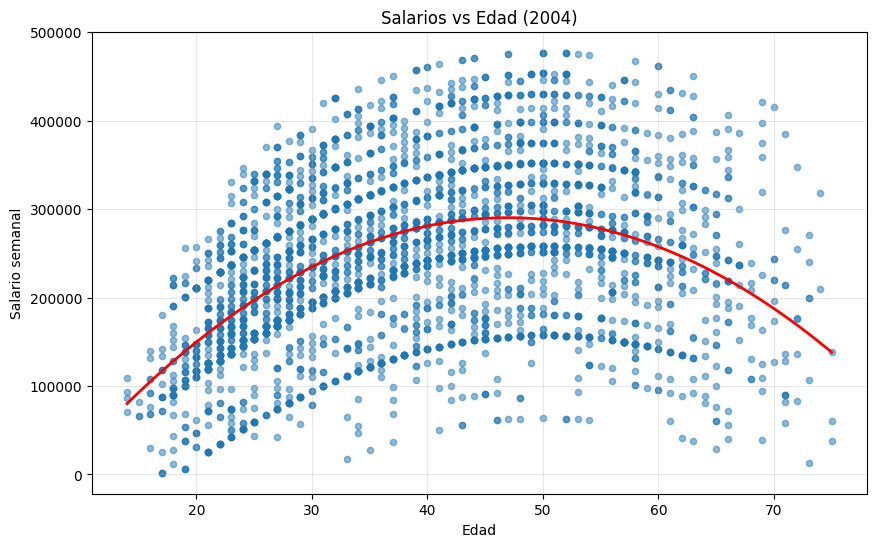

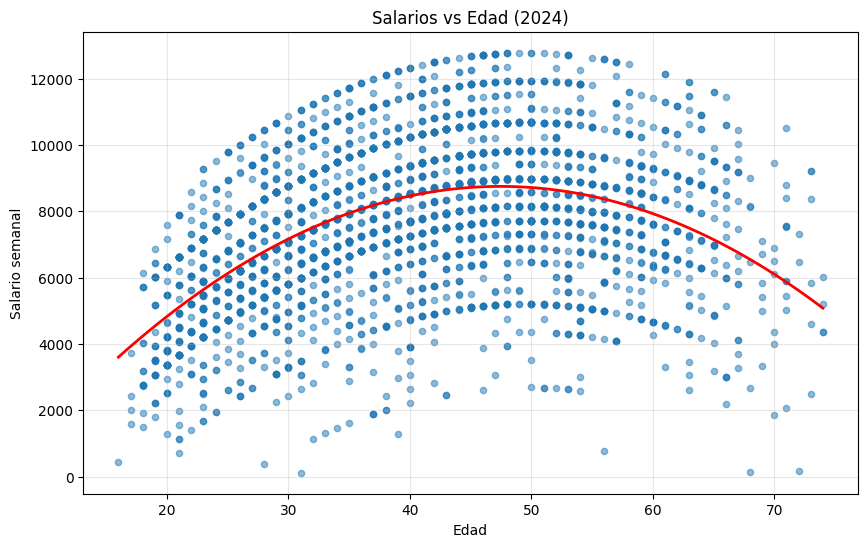

In [13]:
def calcular_educacion(row):
    años = {'Primario': 6, 'Secundario': 12, 'Polimodal': 12, 'Superior no universitario': 15, 'Universitario': 17, 'Terciario': 15}
    nivel, finalizo, año_aprobado = row['CH12'], row['CH13'], row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    if finalizo == 'Sí':
        return años.get(nivel, 0)
    
    base = 6 if nivel in ['Secundario', 'Polimodal'] else (12 if nivel in ['Terciario', 'Superior no universitario', 'Universitario'] else 0)
    try: 
        return base + int(año_aprobado)
    except: 
        return base

def procesar_datos(df, es_2004=False):
    df = df.copy()
    
    # Ajuste inflación 2004
    if es_2004:
        df.loc[df['ANO4'] == 2004, 'P21'] *= 18000
    
    # Variables principales
    df['salario_semanal'] = df['P21'] / 40
    df = df[df['salario_semanal'] > 0]
    q1, q99 = df['salario_semanal'].quantile([0.01, 0.99])
    df = df[(df['salario_semanal'] >= q1) & (df['salario_semanal'] <= q99)]
    
    # Educación
    df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'EGB'], ['No tiene', 'No tiene', 'No tiene', 'No tiene', 'Primario'])
    df['educ'] = df.apply(calcular_educacion, axis=1)
    
    # Demográficas
    df["Edad"] = pd.to_numeric(df['CH06'], errors='coerce').replace('Menos de 1 año', 0).fillna(1)
    df = df[(df['Edad'] >= 14) & (df['Edad'] <= 75)]
    df["Edad2"] = df["Edad"] ** 2
    df["Mujer"] = df["CH04"].map({"Mujer": 1, "Varón": 2})
    df["Cond_OCU"] = df["CAT_OCUP"].map({"Obrero o empleado": 1, "Cuenta propia": 2, "Patrón": 3}).fillna(0)
    
    return df.dropna(subset=['Edad', 'educ', 'Mujer', 'salario_semanal'])

def encontrar_mejor_modelo(df_train, df_test):
    modelos = [
        (['Edad'], 'Edad'),
        (['Edad', 'Edad2'], 'Edad + Edad²'),
        (['Edad', 'Edad2', 'educ'], 'Edad + Edad² + Educación'),
        (['Edad', 'Edad2', 'educ', 'Mujer'], 'Edad + Edad² + Educación + Género'),
        (['Edad', 'Edad2', 'educ', 'Mujer', 'Cond_OCU'], 'Edad + Edad² + Educación + Género + Ocupación'),
    ]
    
    y_train, y_test = df_train['salario_semanal'], df_test['salario_semanal']
    mejor_mse, mejor_nombre, mejores_pred = float('inf'), None, None
    
    for variables, nombre in modelos:
        modelo = sm.OLS(y_train, sm.add_constant(df_train[variables])).fit()
        pred = modelo.predict(sm.add_constant(df_test[variables]))
        mse = mean_squared_error(y_test, pred)
        
        if mse < mejor_mse:
            mejor_mse, mejor_nombre, mejores_pred = mse, nombre, pred
    
    return mejor_nombre, mejores_pred, mejor_mse

def hacer_grafico(df_test, predicciones, modelo_nombre, año):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    mask = predicciones > 0
    edades, pred = df_test['Edad'][mask], predicciones[mask]
    
    ax.scatter(edades, pred, alpha=0.5, s=20)
    z = np.polyfit(edades, pred, 2)
    x_smooth = np.linspace(edades.min(), edades.max(), 100)
    ax.plot(x_smooth, np.poly1d(z)(x_smooth), 'r-', linewidth=2)
    
    ax.set_title(f'Salarios vs Edad ({año})')
    ax.set_xlabel('Edad')
    ax.set_ylabel('Salario semanal')
    ax.grid(True, alpha=0.3)
    
    plt.show()

# Análisis 2004
df_train_04 = pd.read_excel("train_original_2004.xlsx")
df_test_04 = pd.read_excel("test_original_2004.xlsx")
df_train_04 = procesar_datos(df_train_04, es_2004=True)
df_test_04 = procesar_datos(df_test_04, es_2004=True)
mejor_modelo_04, pred_04, mse_04 = encontrar_mejor_modelo(df_train_04, df_test_04)
hacer_grafico(df_test_04, pred_04, mejor_modelo_04, "2004")

# Análisis 2024
df_train_24 = pd.read_excel("train_original_2024.xlsx")
df_test_24 = pd.read_excel("test_original_2024.xlsx")
df_train_24 = procesar_datos(df_train_24, es_2004=False)
df_test_24 = procesar_datos(df_test_24, es_2004=False)
mejor_modelo_24, pred_24, mse_24 = encontrar_mejor_modelo(df_train_24, df_test_24)
hacer_grafico(df_test_24, pred_24, mejor_modelo_24, "2024") 

### C. Métodos de Clasificación y Performance - Punto 5.

Año: 2004
Modelo Logit
Matriz de Confusión:
[[8042    4]
 [ 561  164]]
AUC: 0.8837
Accuracy: 0.9356
Modelo KNN
Matriz de Confusión:
[[7890  156]
 [ 643   82]]
AUC: 0.7174
Accuracy: 0.9089


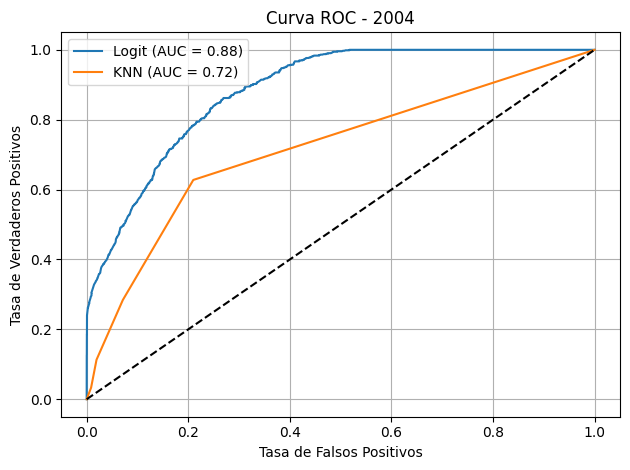

Año: 2024
Modelo Logit
Matriz de Confusión:
[[8546    2]
 [ 292   25]]
AUC: 0.8800
Accuracy: 0.9668
Modelo KNN
Matriz de Confusión:
[[8519   29]
 [ 304   13]]
AUC: 0.6753
Accuracy: 0.9624


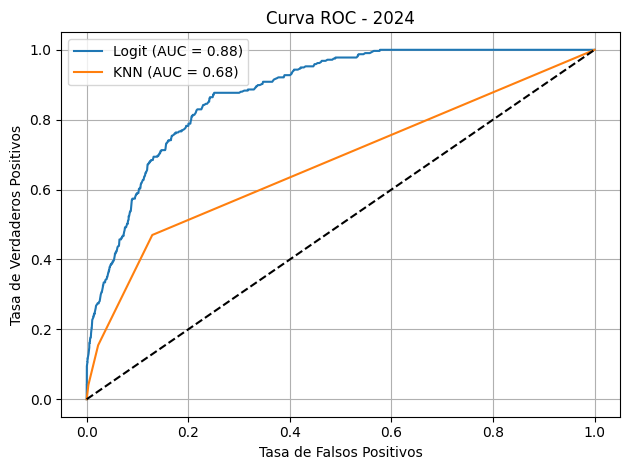

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

años = [2004, 2024]

for año in años:
    print(f"Año: {año}")
    
    train = pd.read_excel(f"train_data_{año}.xlsx")
    test = pd.read_excel(f"test_data_{año}.xlsx")

    X_train = train.drop(columns=['y_desocupado'])
    y_train = train['y_desocupado']

    X_test = test.drop(columns=['y_desocupado'])
    y_test = test['y_desocupado']

    # Modelo Logit
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X_train, y_train)
    prob_logit = logit.predict_proba(X_test)[:, 1]
    pred_logit = (prob_logit > 0.5).astype(int)

    # Modelo KNN (k=5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    prob_knn = knn.predict_proba(X_test)[:, 1]
    pred_knn = (prob_knn > 0.5).astype(int)

    # Métricas
    for modelo, pred, probas in [('Logit', pred_logit, prob_logit), ('KNN', pred_knn, prob_knn)]:
        print(f"Modelo {modelo}")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, pred))
        print(f"AUC: {roc_auc_score(y_test, probas):.4f}")
        print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
        fpr, tpr, _ = roc_curve(y_test, probas)
        plt.plot(fpr, tpr, label=f"{modelo} (AUC = {roc_auc_score(y_test, probas):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"Curva ROC - {año}")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#plt.plot([0, 1], [0, 1], 'k--')
#plt.title(f"Curva ROC - {año}")
#plt.xlabel("Tasa de Falsos Positivos")
#plt.ylabel("Tasa de Verdaderos Positivos")
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.show()

# (Si no incluimos la ultima linea dentro del conjunto "años" podremos visualizar todas las curvas unidas)

Para este caso tomaremos que los valores de la matriz de confusión:

                                predicción
                          real   tn fp
                                 fn tp
Implican que:
* 1 = desocupado
* 0 = ocupado

Como resultado tuvimos: 
### Año 2004

| Modelo Logit | 4 falsos positivos y 561 falsos negativos -> Acerto el 93.5% de los casos. AUC = 0.88 | 
| ---------- | -------- |
| Modelo KNN | 149 falsos positivos y 645 falsos negativos -> Acerto el 91% de los casos. AUC = 0.72 |

### Año 2024

| Modelo Logit | 2 falsos positivos y 292 falsos negativos -> Acerto el 96.7% de los casos. AUC = 0.88 |
| ---------- | -------- |
| Modelo KNN | 38 falsos positivos y 304 falsos negativos -> Acerto el 96% de los casos. AUC = 0.68 |

Deducimos entonces que para todas las métricas que se pidieron, el modelo Logit fue superior en su aprendizaje respecto a la base de entrenamiento. Su accuracy, AUC y curva ROC fueron ampliamente superior a las del modelo KNN con K=5 en ambos periodos.

Podemos decir, entonces:
* Se entreno con una base de entrenamiento de variables independientes a los modelos Logit y KNN para predecir la tasa de desocupación respecto del año 2004 y el 2024. El modelo más preciso a la hora de predecir fue el Logit, prediciendo aproximadamente el 93.5% de los casos para el 2004 y el 96.7% de los casos para el 2024. Es por este motivo que se utilizará para el siguiente inciso.



### C. Métodos de Clasificación y Performance - Punto 6.

In [9]:
no_resp = pd.read_excel("Base_No_Respondieron.xlsx")
X_noresp = pd.get_dummies(no_resp[['CH04', 'CH06', 'CAT_OCUP', 'PP02H', 'CH08']], drop_first=True)
X_noresp = X_noresp.reindex(columns=X_train.columns, fill_value=0) # con esto limpiamos las variables faltantes y las reemplazamos con 0
prob_noresp = logit.predict_proba(X_noresp)[:, 1]
pred_noresp = (prob_noresp > 0.5).astype(int)
proporcion = pred_noresp.mean()
print(f"Proporción predicha como desocupadas: {proporcion:.2%}")

Proporción predicha como desocupadas: 21.52%


Con el modelo Logit, se estima que alrededor del 21.52% de la población dentro de la región "no contestaron" podría estar desocupada. Aproximadamente, la proporción seria 43 de cada 200 personas.